In [387]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import plotly.express as px
from dataclasses import dataclass, field
import random
import ipywidgets as widgets
from IPython.display import display, clear_output

from data_generators import create_prog_data, create_site_data

In [361]:
years = list(range(2020, 2051))

df_prog = create_prog_data()
df_site = create_site_data(years=years)

In [362]:
df_prog.head()

,program1,program2,2020,2021,2022,2023,2024,2025,2026,2027,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,site3,site7.1,91,73,61,59,70,56,111,59,...,49,23,69,97,70,6,63,34,14,63
1,site4,site2.1,71,49,78,55,43,70,99,24,...,107,95,84,0,0,12,71,22,61,71
2,site1,site2.1,57,2,63,28,41,0,36,0,...,64,65,97,71,31,33,23,88,55,23
3,site3,site4.1,72,29,77,44,30,88,0,41,...,47,85,62,28,48,46,59,45,57,80
4,site3,site2.1,35,84,33,25,34,3,41,24,...,12,29,57,38,68,84,88,56,72,32


In [375]:
@dataclass
class Conversions:
    site1: int = field(default_factory=lambda: random.randint(5, 10))
    site2: int = field(default_factory=lambda: random.randint(5, 10))
    site3: int = field(default_factory=lambda: random.randint(5, 10))
    site4: int = field(default_factory=lambda: random.randint(5, 10))

    def get(self, key):
        return getattr(self, key, None)

class DataFrameAnalyzer:
    def __init__(self, dataframe):
        self.df = dataframe.copy()
        self.pattern = re.compile(r'([a-zA-Z]{2}\d{4}|\d{4})')
        self.years = [year for year in self.df.columns if self.pattern.match(year)]
        self.cols = [col for col in self.df.columns if not self.pattern.match(col)]
        self.conversions_data = Conversions()

    def filter_df(self, years=None, sites_per_program=None):
        """

        Parameters:
        - years (list): List of years to include in the sum. Default is None (all years).
        - sites_per_program (dict): Dictionary where keys are programs and values are lists of sites.
                                   Default is None (all sites for all programs).

        Returns:
        - pd.DataFrame: DataFrame containing the sum for each row.
        """
        df_copy = self.df.copy()
        if years is not None:
            df_copy = df_copy[self.cols + years]

        if sites_per_program is not None:
            if (subset_1 := sites_per_program.get("program1","")):
                df_copy = df_copy[df_copy["program1"].isin(subset_1)]
            if (subset_2 := sites_per_program.get("program2","")):
                df_copy = df_copy[df_copy["program2"].isin(subset_2)]
        return df_copy

    def calculate_inflation_rate(self,row,rate):
        return pd.Series([int(value * (1 + rate) ** index) for index, value in enumerate(row)], index=row.index)

    def convert_series(self,row,rate):
        return pd.Series([int((value*1000)*(1/rate)) for index, value in enumerate(row)], index=row.index)

    def apply_inflation_rate(self,df,rate = 0.02, years = None):
        years_to_consider = years if years else self.years
        #df.loc[:, years_to_consider] = df.loc[:, years_to_consider].apply(self.calculate_inflation_rate, axis=1)
        df.loc[:, years_to_consider] = df.loc[:, years_to_consider].apply(lambda row: self.calculate_inflation_rate(row, rate=rate), axis=1)
        return df

    def sum_accross_sites(self, df, years = None):
        """Sum across the specified axis with optional subsets of years and sites for each program."""
        years_to_aggregate = years if years else self.years
        df['Total'] = df.loc[:, years_to_aggregate].sum(axis=1)
        return df

    def convert_all_series(self,df, years = None):
        dfs = []
        years_to_consider = years if years else self.years
        unique_programs = df["program1"].unique().tolist()
        for prog in unique_programs:
            df_subset = df[df["program1"] == prog]
            rate = conversions_data.get(prog)
            df_subset.loc[:, years_to_consider] = df_subset.loc[:, years_to_consider].apply(lambda row: self.convert_series(row, rate=rate), axis=1)
            dfs.append(df_subset)
        return pd.concat(dfs)

    def plot_subsets(self,df):
        """
        Plot line graphs for specified subsets of program names and years.
    
        Parameters:
        - df (pd.DataFrame): Input DataFrame.
        - programs_subset1 (list or None): List of program1 values to include. Default is None (include all).
        - programs_subset2 (list or None): List of program2 values to include. Default is None (include all).
        - years_subset (list or None): List of years to include. Default is None (include all).
    
        Returns:
        - None: Displays the line plot.
        """
    
        # Plot line for each series
        plt.figure(figsize=(10, 6))
    
        for idx, row in df.iterrows():
            program1_label = f'({row["program2"]})'
    
            plt.plot(row.index[2:], row.values[2:], label=program1_label)
    
        plt.xlabel('Year')
        plt.ylabel('Value')
        plt.title('Line Plot for Each Series')
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()

In [376]:
# Example Usage:
# Assuming df_prog is your original DataFrame
df_analyzer = DataFrameAnalyzer(df_prog)

# Sum across columns for specific years and sites per program
sites_per_program = {'program1': ["site4"], 'program2': ['site2.1','site4.1']}
total_subset = df_analyzer.filter_df(years=["2020","2021","2022","2023","2024"], sites_per_program=sites_per_program)
# df_analyzer.apply_inflation_rate(total_subset, rate = .03, years=["2020","2021","2022","2023","2024"])
# df_analyzer.convert_all_series(df = total_subset, years=["2020","2021","2022","2023","2024"])

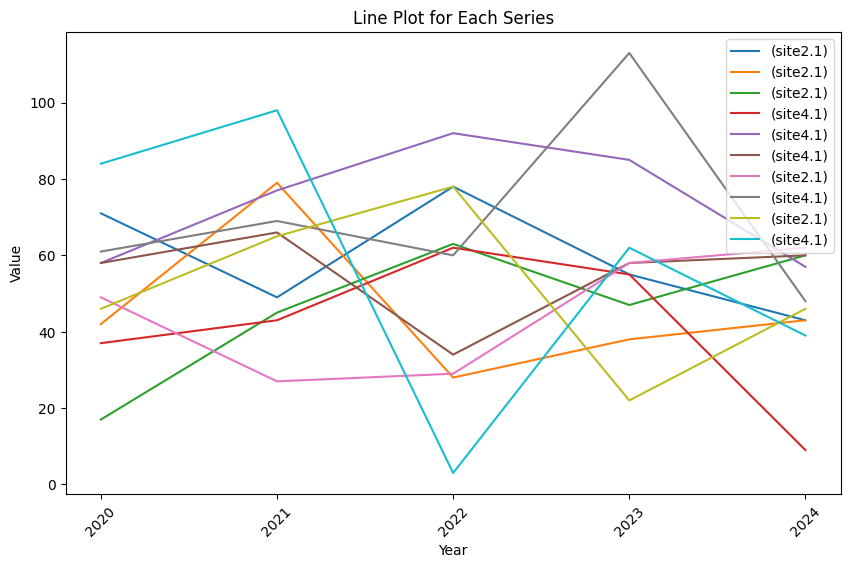

In [378]:
df_analyzer.plot_subsets(total_subset)

In [337]:
melted_df = pd.melt(total_subset, id_vars=['program1', 'program2'], var_name='Year', value_name='Value')

In [347]:
melted_df.groupby(["program1","program2","Year"]).sum().reset_index()

,program1,program2,Year,Value
0,site4,site2.1,2020,225
1,site4,site2.1,2021,265
2,site4,site2.1,2022,276
3,site4,site2.1,2023,220
4,site4,site2.1,2024,254
5,site4,site4.1,2020,298
6,site4,site4.1,2021,353
7,site4,site4.1,2022,251
8,site4,site4.1,2023,373
9,site4,site4.1,2024,213


In [388]:

%matplotlib widget
%matplotlib inline

class InteractiveDataFrameAnalyzer:
    def __init__(self, df):
        self.df_analyzer = DataFrameAnalyzer(df)

        # Options for interactive widgets
        self.inflation_rate_slider = widgets.FloatSlider(value=0.02, min=0, max=1, step=0.01, description='Inflation Rate:')

        # Assuming 'program1' and 'program2' are columns in the original DataFrame
        program1_values = df['program1'].unique()
        self.program1_dropdown = widgets.Dropdown(options=program1_values, description='Program1:')

        program2_values = df['program2'].unique()
        self.program2_multiselect = widgets.SelectMultiple(options=program2_values, value=[], description='Program2:')

        years_values = self.df_analyzer.years
        self.years_multiselect = widgets.SelectMultiple(options=years_values, value=["2020","2021","2022","2023","2024"], description='Years:')

        self.convert_dropdown = widgets.Dropdown(options=['Convert'], value=None, description='Action:')
        # Button and Output for plotting
        self.plot_button = widgets.Button(description='Plot Time Series')
        self.output_plot = widgets.Output()

        # Attach the function to widget events
        self.inflation_rate_slider.observe(self.handle_interaction, names='value')
        self.program1_dropdown.observe(self.handle_interaction, names='value')
        self.program2_multiselect.observe(self.handle_interaction, names='value')
        self.years_multiselect.observe(self.handle_interaction, names='value')
        self.convert_dropdown.observe(self.handle_interaction, names='value')

        self.plot_button.observe(self.handle_interaction, names='value')
        self.output_plot.observe(self.handle_interaction, names='value')

        # Display widgets
        self.display_widgets()

    def display_widgets(self):
        display(self.inflation_rate_slider, self.program1_dropdown,
                self.program2_multiselect, self.years_multiselect, self.convert_dropdown, self.plot_button, self.output_plot)

    def handle_interaction(self, change):
        with self.output_plot:
            clear_output(wait=True)  # Clear the previous output
            years = list(self.years_multiselect.value)
            sites_per_program = {'program1': [self.program1_dropdown.value], 'program2': list(self.program2_multiselect.value)}
            total_subset = self.df_analyzer.filter_df(years=years, sites_per_program=sites_per_program)
            self.df_analyzer.plot_subsets(total_subset)

# Assuming df_prog is your original DataFrame

# Create an instance of the interactive class
interactive_df_analyzer = InteractiveDataFrameAnalyzer(df_prog)

FloatSlider(value=0.02, description='Inflation Rate:', max=1.0, step=0.01)

Dropdown(description='Program1:', options=('site3', 'site4', 'site1', 'site2'), value='site3')

SelectMultiple(description='Program2:', options=('site7.1', 'site2.1', 'site4.1', 'site6.1', 'site1.1', 'site5…

SelectMultiple(description='Years:', index=(0, 1, 2, 3, 4), options=('2020', '2021', '2022', '2023', '2024', '…

Dropdown(description='Action:', options=('Convert',), value=None)

Button(description='Plot Time Series', style=ButtonStyle())

Output()